In [1]:
import numpy as np
import pandas as pd
import xarray as xr
from datetime import datetime, timedelta

from cuml.cluster import DBSCAN as cuDBSCAN
from cuml.ensemble import RandomForestClassifier as cuRF
from cuml.metrics import accuracy_score
import cudf

from imblearn.over_sampling import SMOTE

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Load data and preprocess
fname = '../generalStatistics/goodData_QSwithTAO_with2hrStatsConv.nc'
ds = xr.open_dataset(fname)
ds['mean_WVEL'] = np.sqrt(ds['mean_U10N_x'] ** 2 + ds['mean_U10N_y'] ** 2)
data = ds.to_dataframe()
df = data.copy()

# Normalize selected features for clustering
selectX = ['Speed Difference (QuikSCAT - TAO)',
           'cos(Direction Difference (QuikSCAT - TAO))',
           'sin(Direction Difference (QuikSCAT - TAO))']

X_norm = df[selectX]
X_norm = (X_norm - X_norm.mean()) / X_norm.std()
X_norm_cudf = cudf.DataFrame.from_pandas(X_norm)

# Run DBSCAN clustering using cuML
dbscan = cuDBSCAN(eps=0.15, min_samples=500)
df['label'] = dbscan.fit_predict(X_norm_cudf).to_pandas()

[2025-05-09 14:38:55.688] [CUML] [warning] Batch size limited by the chosen integer type (4 bytes). 18056 -> 14480. Using the larger integer type might result in better performance


/tmp/ipykernel_1364670/3341859535.py:9: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  s = sns.histplot(df, x=xlabel, y = ylabel,#levels=10,
/tmp/ipykernel_1364670/3341859535.py:22: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  s = sns.countplot(df, x='label',hue = 'label', palette = sns.color_palette("bright"), ax = ax)


Text(0.1, 0.95, 'B')

/home/shikhar.rai/anaconda3/envs/rapids-25.04/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)


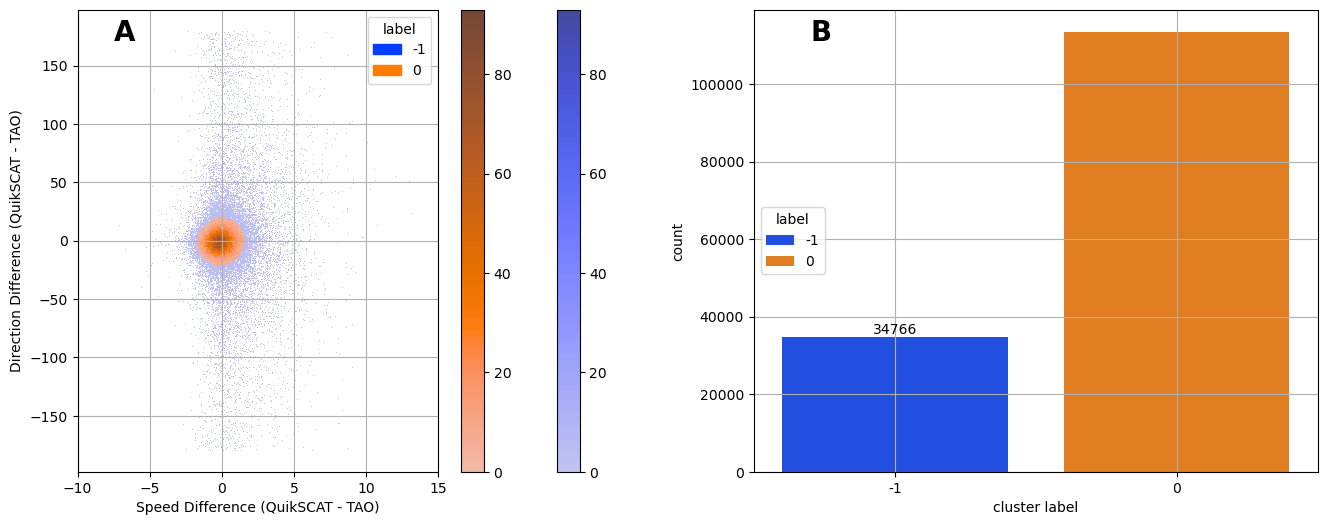

In [2]:
fig,  axes = plt.subplots(ncols = 2, figsize=(16,6))

ax = axes[0]
# ax.remove()  # Remove the existing second subplot
# ax = fig.add_subplot(121, projection='polar')
xlabel = 'Speed Difference (QuikSCAT - TAO)'
ylabel = 'Direction Difference (QuikSCAT - TAO)'

s = sns.histplot(df, x=xlabel, y = ylabel,#levels=10, 
                hue='label', common_norm=True, cbar = True,
                palette = sns.color_palette("bright"), ax = ax)

ax.grid(visible=True, which='both', axis='both')

ax.text(0.1, 0.95, 'A', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 20)

ax.set_xlim(-10,15)

ax = axes[1]
s = sns.countplot(df, x='label',hue = 'label', palette = sns.color_palette("bright"), ax = ax)
s.bar_label(s.containers[0])

ax.grid(visible=True, which='both', axis='both')
ax.set_xlabel('cluster label')
#ax.set_ylabel('cluster label')

ax.text(0.1, 0.95, 'B', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 20)


In [3]:
# Filter by wind speed > 2 m/s
subDF = df[df['Neutral Wind Speed at 10m (TAO)'] > 2].copy()
subDF['SST-AIRT'] = subDF['Sea Surface Temperature (TAO)'] - subDF['Air Temperature (TAO)']

# Relabel: 0 -> rain (1), others -> no rain (0)
subDF['label'] = subDF['label'].apply(lambda x: 1 if x == 0 else 0)

# Features for classification
features = ['Neutral Wind Speed at 10m (TAO)',
            'mean_WSPD',
            'std_WSPD',
            'std_cosWDIR', 
            'std_sinWDIR',
            'SST-AIRT',
            'Relative Humidity (TAO)',
            'mean_SST', 'mean_AIRT', 'mean_SST - AIRT', 'mean_RELH',
            'std_SST', 'std_AIRT',
            'std_SST - AIRT', 'std_RELH']

X = subDF[features]
y = subDF['label']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [4]:
# Apply SMOTE to training data only
sm = SMOTE(random_state=42)
X_train_bal, y_train_bal = sm.fit_resample(X_train, y_train)

# Check class distribution
print("Before SMOTE:\n", y_train.value_counts())
print("After SMOTE:\n", pd.Series(y_train_bal).value_counts())

# Convert to cuDF
X_train_cudf = cudf.DataFrame.from_pandas(X_train_bal)
y_train_cudf = cudf.Series(y_train_bal)
X_test_cudf = cudf.DataFrame.from_pandas(X_test)
y_test_cudf = cudf.Series(y_test)

# Train cuML Random Forest with manual parameter tuning
n_estimators = [500]
max_depths = [80, 100, 150]
min_samples_leaves = [2]
min_samples_splits = [2]

for i in range(len(n_estimators)):
    for j in range(len(max_depths)):
        for k in range(len(min_samples_leaves)):
            for l in range(len(min_samples_splits)):
                model = cuRF(
                    n_estimators=n_estimators[i],
                    max_depth=max_depths[j],
                    max_features='auto',
                    min_samples_leaf=min_samples_leaves[k],
                    min_samples_split=min_samples_splits[l],
                    bootstrap=True,
                    random_state=42,
                    output_type='numpy'
                )
                model.fit(X_train_cudf, y_train_cudf)
                y_pred = model.predict(X_test_cudf)

                print(f'n_estimators = {n_estimators[i]:d}')
                print(f'max_depths = {max_depths[j]:d}')
                print(f'min_samples_leaves = {min_samples_leaves[k]:d}')
                print(f'min_samples_splits = {min_samples_splits[l]:d}')
                print("Accuracy:", accuracy_score(y_test_cudf, y_pred))
                print("\nClassification Report:\n", classification_report(y_test.to_numpy(), y_pred))
                print("\n")


Before SMOTE:
 label
1    90186
0    24579
Name: count, dtype: int64
After SMOTE:
 label
1    90186
0    90186
Name: count, dtype: int64


/home/shikhar.rai/anaconda3/envs/rapids-25.04/lib/python3.12/site-packages/cuml/internals/api_decorators.py:317: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return init_func(self, *args, **kwargs)
/home/shikhar.rai/anaconda3/envs/rapids-25.04/lib/python3.12/site-packages/cuml/internals/api_decorators.py:213: FutureWarning: `max_features='auto'` has been deprecated in 24.06 and will be removed in 25.08. To keep the past behaviour and silence this warning, explicitly set `max_features='sqrt'`.
  ret = func(*args, **kwargs)


n_estimators = 500
max_depths = 80
min_samples_leaves = 2
min_samples_splits = 2
Accuracy: 0.8384218597518472

Classification Report:
               precision    recall  f1-score   support

           0       0.61      0.71      0.65      6159
           1       0.92      0.87      0.89     22533

    accuracy                           0.84     28692
   macro avg       0.76      0.79      0.77     28692
weighted avg       0.85      0.84      0.84     28692





/home/shikhar.rai/anaconda3/envs/rapids-25.04/lib/python3.12/site-packages/cuml/internals/api_decorators.py:317: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return init_func(self, *args, **kwargs)
/home/shikhar.rai/anaconda3/envs/rapids-25.04/lib/python3.12/site-packages/cuml/internals/api_decorators.py:213: FutureWarning: `max_features='auto'` has been deprecated in 24.06 and will be removed in 25.08. To keep the past behaviour and silence this warning, explicitly set `max_features='sqrt'`.
  ret = func(*args, **kwargs)


n_estimators = 500
max_depths = 100
min_samples_leaves = 2
min_samples_splits = 2
Accuracy: 0.8384218597518472

Classification Report:
               precision    recall  f1-score   support

           0       0.61      0.71      0.65      6159
           1       0.92      0.87      0.89     22533

    accuracy                           0.84     28692
   macro avg       0.76      0.79      0.77     28692
weighted avg       0.85      0.84      0.84     28692





/home/shikhar.rai/anaconda3/envs/rapids-25.04/lib/python3.12/site-packages/cuml/internals/api_decorators.py:317: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return init_func(self, *args, **kwargs)
/home/shikhar.rai/anaconda3/envs/rapids-25.04/lib/python3.12/site-packages/cuml/internals/api_decorators.py:213: FutureWarning: `max_features='auto'` has been deprecated in 24.06 and will be removed in 25.08. To keep the past behaviour and silence this warning, explicitly set `max_features='sqrt'`.
  ret = func(*args, **kwargs)


n_estimators = 500
max_depths = 150
min_samples_leaves = 2
min_samples_splits = 2
Accuracy: 0.8384218597518472

Classification Report:
               precision    recall  f1-score   support

           0       0.61      0.71      0.65      6159
           1       0.92      0.87      0.89     22533

    accuracy                           0.84     28692
   macro avg       0.76      0.79      0.77     28692
weighted avg       0.85      0.84      0.84     28692





In [23]:
importances = model.feature_importances_

# Feature names (must match your input order)
feature_names = X_train.columns  # If you're still in pandas

# Create a DataFrame for easy plotting
feat_imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feat_imp_df['Feature'], feat_imp_df['Importance'])
plt.xlabel('Feature Importance')
plt.title('Random Forest Feature Importance (cuML)')
plt.gca().invert_yaxis()  # Most important at top

AttributeError: get_feature_importance

In [9]:
# Convert to cuDF
X_train_cudf = cudf.DataFrame.from_pandas(X_train)
y_train_cudf = cudf.Series(y_train)
X_test_cudf = cudf.DataFrame.from_pandas(X_test)
y_test_cudf = cudf.Series(y_test)

# Train cuML Random Forest

n_estimators = [500]
max_depths = [80, 100, 150]
min_samples_leaves = [2]
min_samples_splits = [2]

for i in range(len(n_estimators)):
    for j in range(len(max_depths)):
        for k in range(len(min_samples_leaves)):
            for l in range(len(min_samples_splits)):
                model = cuRF(
                    n_estimators=n_estimators[i],
                    max_depth=max_depths[j],
                    max_features='auto',
                    min_samples_leaf=min_samples_leaves[k],
                    min_samples_split=min_samples_splits[l],
                    bootstrap=True,
                    random_state=42
                )
                model.fit(X_train_cudf, y_train_cudf)
                y_pred = model.predict(X_test_cudf)
    
                print(f'n_estimators = {n_estimators[i]:d}')
                print(f'max_depths = {max_depths[j]:d}')
                print(f'min_samples_leaves = {min_samples_leaves[k]:d}')
                print(f'min_samples_splits = {min_samples_splits[l]:d}')
                # Evaluate
                print("Accuracy:", accuracy_score(y_test_cudf, y_pred))
                print("\nClassification Report:\n", classification_report(y_test.to_numpy(), y_pred.to_numpy()))
                print("\n")



/home/shikhar.rai/anaconda3/envs/rapids-25.04/lib/python3.12/site-packages/cuml/internals/api_decorators.py:317: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return init_func(self, *args, **kwargs)
/home/shikhar.rai/anaconda3/envs/rapids-25.04/lib/python3.12/site-packages/cuml/internals/api_decorators.py:213: FutureWarning: `max_features='auto'` has been deprecated in 24.06 and will be removed in 25.08. To keep the past behaviour and silence this warning, explicitly set `max_features='sqrt'`.
  ret = func(*args, **kwargs)


n_estimators = 500
max_depths = 80
min_samples_leaves = 2
min_samples_splits = 2
Accuracy: 0.861703610762582

Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.52      0.62      6159
           1       0.88      0.96      0.92     22533

    accuracy                           0.86     28692
   macro avg       0.82      0.74      0.77     28692
weighted avg       0.85      0.86      0.85     28692





/home/shikhar.rai/anaconda3/envs/rapids-25.04/lib/python3.12/site-packages/cuml/internals/api_decorators.py:317: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return init_func(self, *args, **kwargs)
/home/shikhar.rai/anaconda3/envs/rapids-25.04/lib/python3.12/site-packages/cuml/internals/api_decorators.py:213: FutureWarning: `max_features='auto'` has been deprecated in 24.06 and will be removed in 25.08. To keep the past behaviour and silence this warning, explicitly set `max_features='sqrt'`.
  ret = func(*args, **kwargs)


n_estimators = 500
max_depths = 100
min_samples_leaves = 2
min_samples_splits = 2
Accuracy: 0.861703610762582

Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.52      0.62      6159
           1       0.88      0.96      0.92     22533

    accuracy                           0.86     28692
   macro avg       0.82      0.74      0.77     28692
weighted avg       0.85      0.86      0.85     28692





/home/shikhar.rai/anaconda3/envs/rapids-25.04/lib/python3.12/site-packages/cuml/internals/api_decorators.py:317: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return init_func(self, *args, **kwargs)
/home/shikhar.rai/anaconda3/envs/rapids-25.04/lib/python3.12/site-packages/cuml/internals/api_decorators.py:213: FutureWarning: `max_features='auto'` has been deprecated in 24.06 and will be removed in 25.08. To keep the past behaviour and silence this warning, explicitly set `max_features='sqrt'`.
  ret = func(*args, **kwargs)


n_estimators = 500
max_depths = 150
min_samples_leaves = 2
min_samples_splits = 2
Accuracy: 0.861703610762582

Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.52      0.62      6159
           1       0.88      0.96      0.92     22533

    accuracy                           0.86     28692
   macro avg       0.82      0.74      0.77     28692
weighted avg       0.85      0.86      0.85     28692





In [ ]:
# Optional: plot histogram of clusters
fig, axes = plt.subplots(ncols=2, figsize=(16, 6))
sns.histplot(df, x='Speed Difference (QuikSCAT - TAO)', y='Direction Difference (QuikSCAT - TAO)',
             hue='label', palette=sns.color_palette("bright"), ax=axes[0], cbar=True)
sns.countplot(x='label', data=df, palette=sns.color_palette("bright"), ax=axes[1])
axes[1].bar_label(axes[1].containers[0])
plt.tight_layout()
plt.show()